# Sarokpontok keresése Harris sarokpont detektor segítségével OpenCV-ben

## A Harris sarokdetektor bemutatása

A sarokdetektorok általában olyan pontokat keres a képen, ahol a gradiens minden irányban nagy. A Harris sarokdetektor egy "*sarkossági*" értéket jelez a képen, mivel nem minden pontról lehet eldönteni, hogy valóban sarokpont-e. 

Legyen $I$ képmátrix.Tekintsünk egy $E(u,v)$ itenzitásváltozási függvényt $[u,v]$ eltolással a következőképpen:

$$
E(u,v) = \sum_\limits{x,y} w(x,y) (I(x,y) - I(x+u, y+v))^2 ,
$$
ahol $w(x,y)$ egy ablakfüggvény $I(x+u, y+v)$ az eltolt intenzitás, $I(x,y)$ pedig a kép intenzitása az $(x,y)$ pontban. 

Egy $f(x+u,y+v)$ függvényt közelíthetünk a Taylor sorfejtésével. Ebben az esetben az elsőrendű közelítést vesszük figyelembe. 
$$
I(x+u, y+v) \approx I(x,y) u I_x + v I_y
$$
Ebből következik, hogy 
\begin{array}
\bigskip       & \sum (I(x,y) - I(x+u, y+v))^2  \\
\approx & \sum (I(x,y) - I(x,y) +uI_x +vI_y)^2 \\
=  & \sum u^2I_x^2 + 2uvI_xI_y+v^2I_y^2 \\
= & \sum \begin{bmatrix}u & v\end{bmatrix} \begin{bmatrix}I_x^2 & I_xI_y \\ I_xI_y & I_y^2 \end{bmatrix}  \begin{bmatrix}u\\v\end{bmatrix}\\ 
= & \begin{bmatrix}u & v\end{bmatrix} \bigg( \sum \begin{bmatrix}I_x^2 & I_xI_y \\ I_xI_y & I_y^2 \end{bmatrix} \bigg) \begin{bmatrix}u\\v\end{bmatrix}\\ 
\end{array}

Az $E(u,v)$ intezitásváltozási függvény tehát közelíthető az alábbi módon:
$$
E(u,v) \cong \begin{bmatrix}u & v\end{bmatrix} M \begin{bmatrix}u \\ v\end{bmatrix},
$$ 
ahol $M$ a kép deriváltjaiból számított $2\times 2$-es mátrix:
$$
M = \sum_{x,y} w(x,y) \begin{bmatrix}I_x^2 & I_xI_y \\ I_xI_y & I_y^2 \end{bmatrix}
$$
A $w(x,y)$ egy súlyfüggvény (az egyszerűség kedvéért lehet konstans 1). 

### A sarkossági mérőszám
A fenti egyenletekből megkaphatjuk az $R$ sarkossági mérőszámot:
$$
R = det(M) - k (trace(M))^2
$$
ahol 
* $det(M)$ az $M$ mátrix determinánsa, $det(M) = \lambda_1 \lambda_2$
* $trace(M)$ az $M$ mátrix nyoma, $trace(M) = \lambda_1 + \lambda_2$
* $\lambda_1$ és $\lambda_2$ pedig az $M$ mátrix sajátértékei,
* $k$ egy empirikus úton meghatározott konstans érték,(k= 0.004-00.6)

A kis $|R|$ értéke kicsi, akkor ott lapos régió van, $R$ értéke nagy, akkor ott sarokpont található. Ha $R$ értéke negatív, akkor ott él van.

### A Harris sarokdetektor algoritmusa

1. Számítsuk ki az $I$ kép $x$ és $y$ irányú deriváltját. Jelölje ezeket rendre $I_x$ és $I_y$.
2. Számítsuk ki a deriváltak szorzatát minden $(p_x,p_y)$ képpontra:
$$
I_{xx}(p_x,p_y) = I_x(p_x,p_y) \cdot I_x(p_x,p_y) \\
I_{xy}(p_x,p_y) = I_x(p_x,p_y)\cdot I_y(p_x,p_y) \\
I_{yy}(p_x,p_y) = I_y(p_x,p_y) \cdot I_y(p_x,p_y) 
$$
3. Minden pixelre számoljuk ki a deriváltak összegét, $S_{xx}$-t, $S_{xy}$-t és $S_{yy}$-t az adott eltolási környezeten belül. 
4. Számoljuk ki minden $(x,y)$ pontra a $H(x,y)$ értékét. 
$$
H(x,y) = \begin{bmatrix} S_{xx}(x,y) & S_{xy}(x,y) \\  S_{xy}(x,y) & S_{xx}(x,y) \end{bmatrix}
$$
5. Számoljuk ki a sarkossági függvényt minden képpontra: 
$$
R(x,y) = det (H) - k(trace (H))^2
$$
6. Küszöböljük a kapott képet valamilyen küszöbértékkel. 

# Példaprogram OpenCV-ben

Az alábbi program az input képen keres jellemzőpontokat a Shi-Tomasi sarokdetektorral. A képet a notebook-fájl mellé érdemes elhelyezni, vagy át kell írni az elérési útvonalat.

A lépések a következők: 
1. Megnyitjuk a képet.
2. Az RGB színes képet szürkeárnyalatosság konvertáljuk és a továbbiakban ezzel a változattal dolgozunk.
3. Beállítjuk a detektor paramétereit (blokkméret, apertúra mérete, a *k* paraméter).
4. Elvégezzük a sarokpont detektálást a *cornerHarris()* függvénynel. Az eredményt a *cornerness* képben kapjuk, amely a sarkossági válaszfüggvény értékeit tartalmazza.
5. Meghatározzuk a minimum és maximum értékeket.
6. Meghatározunk egy küszöbértéket.
7. Kirajzoljuk és kimentjük a küszöbölt sarkossági képet.


min:-4042235.25
max:70680832.0


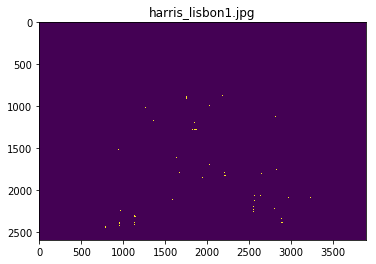

In [3]:
import cv2
import numpy as np
from matplotlib import pyplot as plt


SOURCE_IMAGE='lisbon1.jpg'
OUTPUT_IMAGE='harris_lisbon1.jpg'

## kép beolvasása
img = cv2.imread(SOURCE_IMAGE);

## a képet szürkeárnyalatossá konvertáljuk
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

## sarokpontok keresése Harris sarokdetektorral
##  - meg kell adnunk az alábbi paramétereket:
blockSize = 2    # az ablakméret a sajátérték és sajátvektor számításhoz
apertureSize = 3 # a Sobel operátor ablakmérete
k = 0.004        # a Harris sarokdetektor paramétere (lásd a képletet a leírásban) 
gray_img = np.float32(gray_img)
cornerness = cv2.cornerHarris(gray_img, blockSize, apertureSize, k)
#cornerness = cv2.normalize(cornerness,None)
cv2.imwrite('cornerness.jpg', cornerness)


## a kapott kép még csak a sarkossági válaszfüggvényt tartalmazza
## ahhoz, hogy ténylegesen sarokpontokat kapjunk küszöbölnünk kell
## kiszámoljuk a minimális és maximális sarkosságot a képen és 
## határozzuk meg a küszöböt (ez képenként változhat).
minval, maxval, _, _ = cv2.minMaxLoc(cornerness)
threshold = 0.06 * maxval
print("min:" + str(minval))
print("max:" + str(maxval))
ret, corner_img = cv2.threshold(cornerness, threshold, 255, cv2.THRESH_BINARY); 
cv2.imwrite(OUTPUT_IMAGE, corner_img)

plt.imshow(corner_img);
plt.title(OUTPUT_IMAGE)
plt.show()